In [1]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [2]:
!mkdir data

In [3]:
!kaggle datasets download -d kenjee/z-by-hp-unlocked-challenge-3-signal-processing

100% 602M/604M [00:05<00:00, 139MB/s]
100% 604M/604M [00:05<00:00, 113MB/s]


In [4]:
!unzip "/content/z-by-hp-unlocked-challenge-3-signal-processing.zip" -d data

Archive:  /content/z-by-hp-unlocked-challenge-3-signal-processing.zip
  inflating: data/Forest Recordings/recording_00.mp3  
  inflating: data/Forest Recordings/recording_01.mp3  
  inflating: data/Forest Recordings/recording_02.mp3  
  inflating: data/Forest Recordings/recording_03.mp3  
  inflating: data/Forest Recordings/recording_04.mp3  
  inflating: data/Forest Recordings/recording_05.mp3  
  inflating: data/Forest Recordings/recording_06.mp3  
  inflating: data/Forest Recordings/recording_07.mp3  
  inflating: data/Forest Recordings/recording_08.mp3  
  inflating: data/Forest Recordings/recording_09.mp3  
  inflating: data/Forest Recordings/recording_10.mp3  
  inflating: data/Forest Recordings/recording_11.mp3  
  inflating: data/Forest Recordings/recording_12.mp3  
  inflating: data/Forest Recordings/recording_13.mp3  
  inflating: data/Forest Recordings/recording_14.mp3  
  inflating: data/Forest Recordings/recording_15.mp3  
  inflating: data/Forest Recordings/recording_16.m

In [5]:
!pip install -q tensorflow_io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 10.6 MB/s eta 0:00:00


## Load Dependencies

In [6]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_io as tfio

## Build Data loading Function

In [7]:
CAPUCHIN_FILE = os.path.join("data", 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

In [8]:
NOT_CAPUCHIN_FILE

'data/Parsed_Not_Capuchinbird_Clips/afternoon-birds-song-in-forest-0.wav'

In [9]:
# Here 16k = 16Hz and mono = single channel
def load_wav_16k_mono(filename):
  # Load encoded wav file
  file_contents = tf.io.read_file(filename)
  # Decoded wav (tensors by channel)
  wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels = 1)
  # Remove trailing axis
  wav = tf.squeeze(wav, axis=-1)
  sample_rate = tf.cast(sample_rate, dtype=tf.int64)
  # Goes from 44100hz to 16000hz - amplitude of the audio signal
  wav = tfio.audio.resample(wav, rate_in = sample_rate, rate_out = 16000)

  return wav

In [10]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

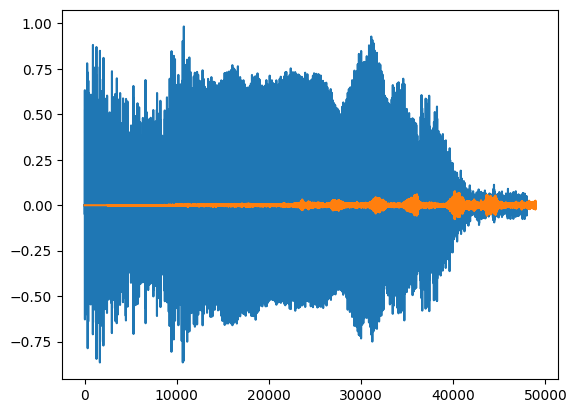

In [11]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

## Create Tensorflow Dataset

### Define path to Positive and Negative data

In [12]:
POS = os.path.join('data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')

In [13]:
NEG

'data/Parsed_Not_Capuchinbird_Clips'

### Create Tensorflow Dataset

In [14]:
pos = tf.data.Dataset.list_files(POS + '/*.wav')
neg = tf.data.Dataset.list_files(NEG + '/*.wav')

In [15]:
pos.as_numpy_iterator().next()

b'data/Parsed_Capuchinbird_Clips/XC178167-1.wav'

### Add labels and Combine Positive and Negative Samples

In [16]:
positives = tf.data.Dataset.zip(pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos))))
negatives = tf.data.Dataset.zip(neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg))))
data = positives.concatenate(negatives)

In [17]:
print(positives.as_numpy_iterator().next())
print(negatives.as_numpy_iterator().next())

(b'data/Parsed_Capuchinbird_Clips/XC216010-6.wav', 1.0)
(b'data/Parsed_Not_Capuchinbird_Clips/sparrow-sound-effect-11.wav', 0.0)


In [18]:
data.shuffle(10000).as_numpy_iterator().next()

(b'data/Parsed_Not_Capuchinbird_Clips/bobwhite-quail-sound-10.wav', 0.0)

## Determine Average lenght of Capuchin Call

In [19]:
# lenghts = []
# for file in os.listdir(os.path.join('data', 'Parsed_Capuchinbird_Clips')):
#   tensor_wave = load_wav_16k_mono(os.path.join('data', 'Parsed_Capuchinbird_Clips', file))
#   lenghts.append(len(tensor_wave))

# Load waveform tensors for all files
wave_tensors = []
for file in os.listdir(os.path.join('data', 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('data', 'Parsed_Capuchinbird_Clips', file))
    wave_tensors.append(tensor_wave)

# Calculate lengths
lengths = [len(tensor_wave) for tensor_wave in wave_tensors]

In [20]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [21]:
54156/16000 # Average time of capuchin call

3.38475

In [22]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [23]:
32000/16000 # Min time of capuchin call

2.0

In [24]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

In [25]:
80000/16000 # Max time of capuchin call

5.0

## Build Preprocessing Function to Convert to Spectrogram

### Build Preprocessing Function

In [26]:
def preprocess(file_path, label):
  wav = load_wav_16k_mono(file_path)
  wav = wav[:48000] # take first 48000 sample
  zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32) # all wav has not size of 48000 some are less than that
  wav = tf.concat([zero_padding, wav], 0)
  spectogram = tf.signal.stft(wav, frame_length = 320, frame_step=32)
  spectogram = tf.abs(spectogram)
  spectogram = tf.expand_dims(spectogram, axis=2)
  return spectogram, label

In [27]:
wav = load_wav_16k_mono('/content/data/Parsed_Capuchinbird_Clips/XC216010-2.wav')
wav = wav[:48000]
zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32) # all wav has not size of 48000 some are less than that
wav = tf.concat([zero_padding, wav], 0)
wav

<tf.Tensor: shape=(48000,), dtype=float32, numpy=
array([-7.7796338e-09,  2.1394984e-08,  3.4943277e-08, ...,
       -6.4268019e-03, -2.3669361e-03,  6.0037142e-03], dtype=float32)>

In [28]:
spectogram = tf.signal.stft(wav, frame_length = 320, frame_step=32)
spectogram = tf.abs(spectogram)
spectogram = tf.expand_dims(spectogram, axis=2)
spectogram

<tf.Tensor: shape=(1491, 257, 1), dtype=float32, numpy=
array([[[2.8518556e-02],
        [5.2006140e-02],
        [7.9846762e-02],
        ...,
        [4.8150596e-05],
        [2.2893502e-05],
        [1.5659258e-05]],

       [[8.9279655e-03],
        [3.1808279e-02],
        [7.6603822e-02],
        ...,
        [5.3015116e-05],
        [2.5820013e-05],
        [1.0512769e-05]],

       [[4.1457126e-03],
        [2.2222113e-02],
        [6.3931599e-02],
        ...,
        [5.6211964e-05],
        [2.5307674e-05],
        [2.9494986e-06]],

       ...,

       [[2.6369933e-02],
        [1.8116897e-02],
        [7.0236232e-03],
        ...,
        [4.5964640e-05],
        [1.5370173e-05],
        [3.1627715e-06]],

       [[2.7723266e-02],
        [2.4285445e-02],
        [2.0582834e-02],
        ...,
        [4.9743488e-05],
        [1.5296053e-05],
        [2.9932708e-06]],

       [[2.3023881e-02],
        [2.6062543e-02],
        [3.3363122e-02],
        ...,
        [6.1420207

### Test Out the Function and Viz the Spectrogram

In [29]:
filepath, label = negatives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [30]:
spectogram, label = preprocess(filepath, label)

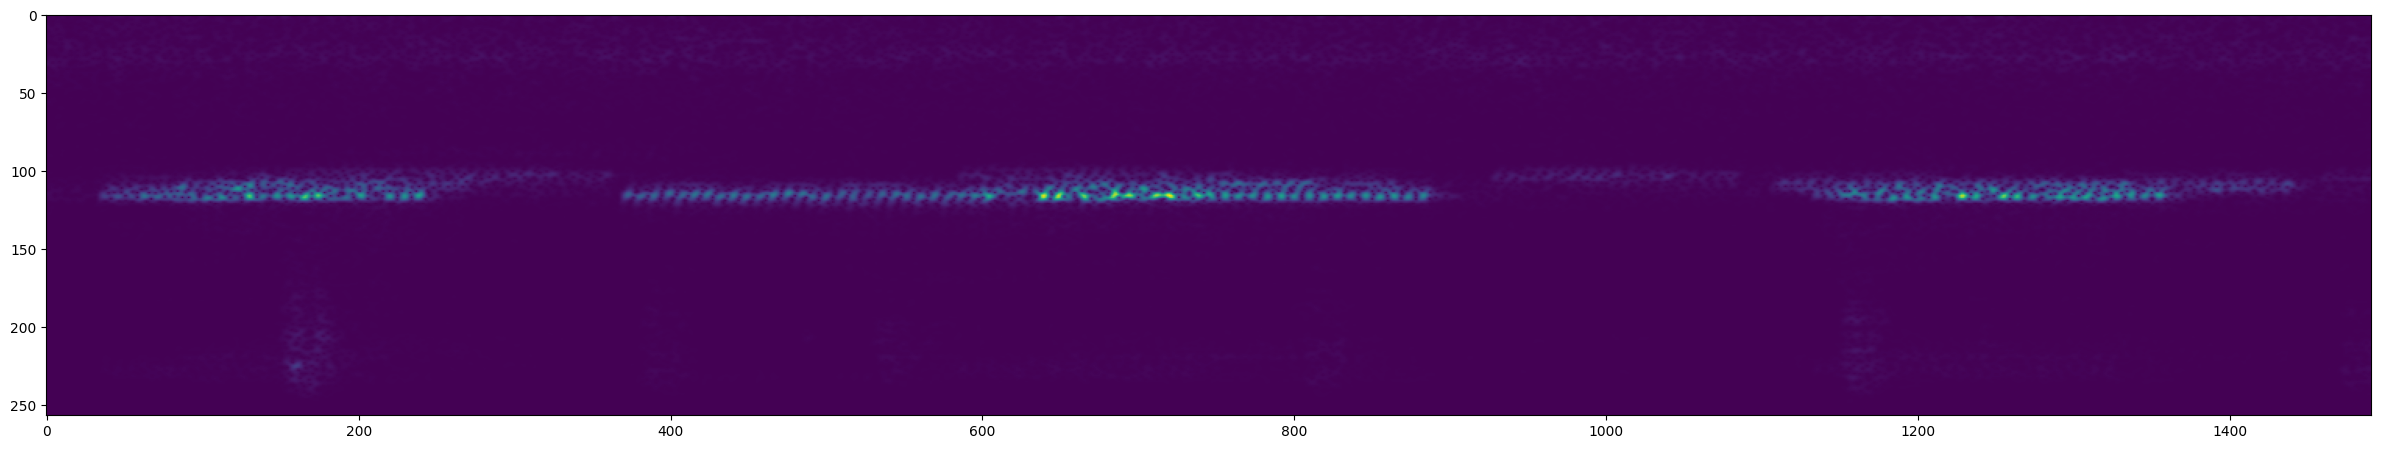

In [31]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectogram)[0])
plt.show()

## Create Training and Testing Partitions

### Create a Tensorflow Data Pipeline

In [32]:
data = data.map(preprocess)
data = data.cache() # after the first pass through the dataset, subsequent epochs don't need to reload and preprocess the data from scratch. Instead,
                    # Instead, the preprocessed data is reused from the cache, resulting in faster training iterations
data = data.shuffle(buffer_size=10000)
data = data.batch(16)
data = data.prefetch(8)

In [33]:
len(data)*.7 # 70% in training

35.699999999999996

### Split in Training and Testing

In [34]:
train = data.take(36)
test = data.skip(36).take(15)

### Test one batch

In [35]:
samples, labels = train.as_numpy_iterator().next()

In [36]:
print(samples.shape)
print(labels.shape)

(16, 1491, 257, 1)
(16,)


## Build Deep Learning Models

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [38]:
# model = Sequential()
# model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
# model.add(Conv2D(16, (3,3), activation='relu'))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))

model = Sequential()

model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 744, 127, 16)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 744, 127, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 742, 125, 64)      9280      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 371, 62, 64)       0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 371, 62, 64)       0

In [40]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

### Fit Model, View Loss and KPI Plots

In [41]:
hist = model.fit(train, epochs=15, validation_data=test)

Epoch 1/15
36/36 [==============================] - 26s 337ms/step - loss: 0.4201 - recall: 0.8712 - precision: 0.8987 - val_loss: 0.0806 - val_recall: 1.0000 - val_precision: 0.9492
Epoch 2/15
36/36 [==============================] - 10s 276ms/step - loss: 0.1182 - recall: 0.9441 - precision: 0.9744 - val_loss: 0.0164 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 3/15
36/36 [==============================] - 9s 242ms/step - loss: 0.0389 - recall: 0.9808 - precision: 0.9808 - val_loss: 0.0374 - val_recall: 0.9825 - val_precision: 0.9655
Epoch 4/15
36/36 [==============================] - 9s 240ms/step - loss: 0.0354 - recall: 0.9869 - precision: 0.9805 - val_loss: 0.0110 - val_recall: 1.0000 - val_precision: 0.9836
Epoch 5/15
36/36 [==============================] - 8s 235ms/step - loss: 0.0553 - recall: 0.9724 - precision: 0.9792 - val_loss: 0.0077 - val_recall: 0.9825 - val_precision: 1.0000
Epoch 6/15
36/36 [==============================] - 9s 251ms/step - loss: 0.0137 - recal

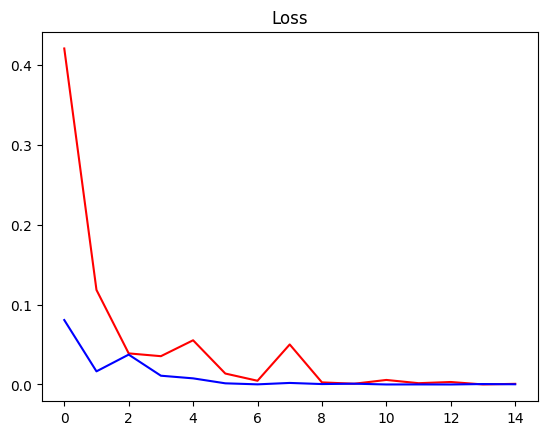

In [42]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

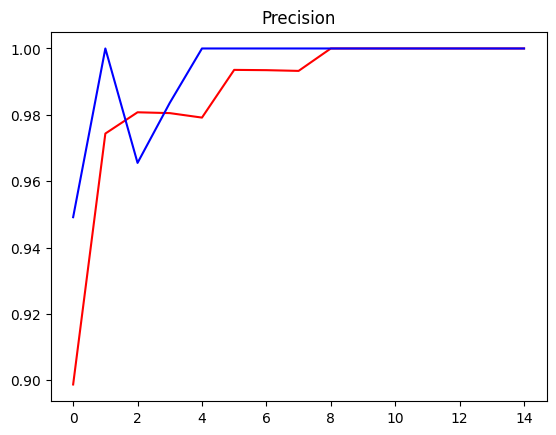

In [43]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

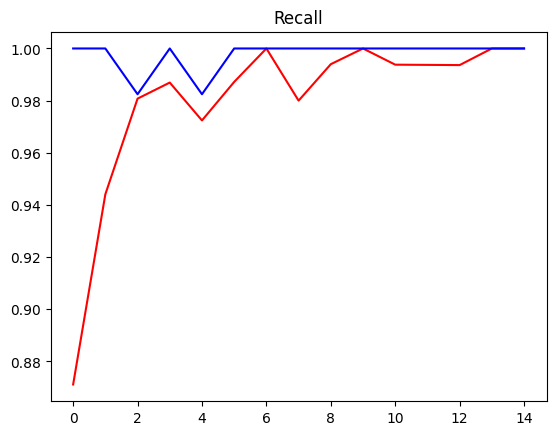

In [44]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

## Make Prediction on Single Clip

In [45]:
X_test, y_test = test.as_numpy_iterator().next()

In [46]:
X_test.shape

(16, 1491, 257, 1)

In [47]:
y_test.shape

(16,)

In [48]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 189ms/step


### Conver Logits to classes


In [49]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [50]:
yhat

[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]

In [51]:
y_test.astype(int)

array([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

In [52]:
tf.math.reduce_sum(yhat).numpy()

3

In [53]:
tf.math.reduce_sum(y_test).numpy()

3.0

## Build Forest Parsing Functions

### Load up MP3s

In [54]:
def load_mp3_16k_mono(filename):
  """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
  res = tfio.audio.AudioIOTensor(filename)
  # Convert to tensor and combine channels
  tensor = res.to_tensor()
  tensor = tf.math.reduce_sum(tensor, axis=1) / 2
  # Extract sample rate and cast
  sample_rate = res.rate
  sample_rate = tf.cast(sample_rate, dtype=tf.int64)
  # Resample to 16 khz
  wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)

  return wav

In [87]:
mp3 = os.path.join('data', 'Forest Recordings', 'recording_16.mp3')

In [88]:
wav = load_mp3_16k_mono(mp3)

In [89]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [90]:
samples, index = audio_slices.as_numpy_iterator().next()

In [91]:
len(audio_slices)

60

In [92]:
samples.shape

(1, 48000)

### Function to Convert Clips into Windowed Spectograms

In [93]:
def preprocess_mp3(sample, index):
  sample = sample[0]
  zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
  wav = tf.concat([zero_padding, sample], 0)
  spectogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
  spectogram = tf.abs(spectogram)
  spectogram = tf.expand_dims(spectogram, axis=2)
  return spectogram

### Convert Longer Clips into Windows and Make Predictions

In [94]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=47999, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [95]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.99 else 0 for prediction in yhat]

1/1 [==============================] - 0s 416ms/step


In [96]:
yhat

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [97]:
len(yhat)

60

### Group Consecutives Detections

In [98]:
from itertools import groupby

In [99]:
yhat = [key for key, group in groupby(yhat)]

In [100]:
yhat

[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]

In [101]:
calls = tf.math.reduce_sum(yhat).numpy()

In [102]:
calls

5

## Make Prediction

### Loop over all recordings and make predictions

In [104]:
results = {}
for file in os.listdir(os.path.join('data', 'Forest Recordings')):
  FILEPATH = os.path.join('data', 'Forest Recordings', file)

  wav = load_mp3_16k_mono(FILEPATH)
  audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
  audio_slices = audio_slices.map(preprocess_mp3)
  audio_slices = audio_slices.batch(64)

  yhat = model.predict(audio_slices)

  results[file] = yhat

1/1 [==============================] - 1s 526ms/step


In [105]:
results

{'recording_67.mp3': array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], dtype=float32),
 'recording_37.mp3': array([[3.46297966e-05],
        [5.05029748e-05],
        [4.89434296e-06],
        [2.41316352e-02],

### Conver predictions into classes

In [108]:
class_preds = {}
for file, logits in results.items():
  class_preds[file] = [1 if predictions > 0.99 else 0 for predictions in logits]
class_preds

{'recording_67.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_37.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_80.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_61.mp3': [0,
  1,
  0,
  

### Group Consecutive Detections

In [109]:
postprocessed={}
for file, scores in class_preds.items():
  postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_67.mp3': 0,
 'recording_37.mp3': 3,
 'recording_80.mp3': 1,
 'recording_61.mp3': 8,
 'recording_59.mp3': 13,
 'recording_68.mp3': 1,
 'recording_95.mp3': 5,
 'recording_36.mp3': 6,
 'recording_26.mp3': 2,
 'recording_10.mp3': 5,
 'recording_76.mp3': 8,
 'recording_28.mp3': 15,
 'recording_52.mp3': 0,
 'recording_79.mp3': 0,
 'recording_60.mp3': 5,
 'recording_83.mp3': 0,
 'recording_63.mp3': 14,
 'recording_77.mp3': 13,
 'recording_32.mp3': 2,
 'recording_53.mp3': 0,
 'recording_74.mp3': 3,
 'recording_91.mp3': 0,
 'recording_99.mp3': 5,
 'recording_06.mp3': 5,
 'recording_41.mp3': 0,
 'recording_20.mp3': 0,
 'recording_78.mp3': 9,
 'recording_93.mp3': 5,
 'recording_71.mp3': 5,
 'recording_73.mp3': 0,
 'recording_14.mp3': 0,
 'recording_57.mp3': 4,
 'recording_82.mp3': 0,
 'recording_13.mp3': 0,
 'recording_51.mp3': 2,
 'recording_94.mp3': 3,
 'recording_27.mp3': 0,
 'recording_11.mp3': 3,
 'recording_84.mp3': 12,
 'recording_46.mp3': 12,
 'recording_25.mp3': 14,
 'recordi

### Export Results

In [110]:
import csv

In [114]:
with open('results.csv', 'w', newline='') as f:
  writer = csv.writer(f, delimiter=',')
  writer.writerow(['recording','capuchin_calls'])
  for key, value in postprocessed.items():
    writer.writerow([key,value])